# Uebung 4 Mehrklassenklassifikation mit Neuronalen Netzen

## Setup

### Util function

In [1]:
## Konventiere Bildformate in Ziel

def change_image_format_batch(src_path, tar_path, fmt_in, fmt_out ):
  '''
  Bildkonvertierung für alle Bilder im Stammordner von Ausgangformat in Zielforamt
  Args:
    src_path : 'string',  Stammordner,aus dem wir Bilder einlesen 
    tar_path : 'string', Stammordner, wo wir Ergebnis ablegen
    fmt_in  : 'string',  originale Bildformat
    fmt_out : 'string',  erwartete Bildformat
  '''
  import glob,os
  from PIL import Image

  if os.path.exists(src_path)==False:
    raise FileNotFoundError( 'No such file or directory:'+ src_path)
  
  img_dict=dict()
  directorys=[ subpath for subpath in os.listdir(src_path) if   os.path.isdir( os.path.join(src_path,subpath) )   ]
  #################################################
  if len(directorys)==0:
    imgPaths=glob.glob(os.path.join(src_path,'*.'+ fmt_in))
    if os.path.exists(tar_path)==False:
      os.makedirs(tar_path)
    for imgPath in imgPaths:
      im=Image.open(imgPath)
      _,imgNamePPM=os.path.split(imgPath)
      imgName,PPM=os.path.splitext(imgNamePPM)
      im.save(os.path.join(tar_path,imgName+'.'+ fmt_out))
    return


  #################################################
  for subdir in directorys:
    img_dict[subdir]=glob.glob(os.path.join(src_path,subdir,'*.'+ fmt_in))
  
  if os.path.exists(tar_path)==False:
    os.makedirs(tar_path)
  # erstelle Ordner
  for subdir,imgPaths in img_dict.items():
    newLongdir=os.path.join(tar_path,subdir)
    if os.path.exists(newLongdir)==False:
      os.makedirs(newLongdir)
    for imgPath in imgPaths:
      im=Image.open(imgPath)
      _,imgNamePPM=os.path.split(imgPath)
      imgName,PPM=os.path.splitext(imgNamePPM)
      im.save(os.path.join(tar_path,subdir,imgName+'.'+ fmt_out))


### Prepare

### GPU Check

In [2]:
import tensorflow as tf
tf.test.gpu_device_name() 

'/device:GPU:0'

### form PPM to JPG

In [105]:
import os 
# konvertiere Bild von PPM in JPEG
## definiere Datenpfad
PPM_TEST_IMAGE_ORDNER=r'DataUE03\GTSRB\Final_Test\Images'
JPG_TEST_IMAGE_ORDNER=r'DataUE03\GTSRB\Final_Test\ImagesJPG'
PPM_TRAIN_IMAGE_ORDNER=r'DataUE03\GTSRB\Final_Training\Images'
JPG_TRAIN_IMAGE_ORDNER=r'DataUE03\GTSRB\Final_Training\ImagesJPG'
MAPPING_CSV_PATH=r'DataUE03\GTSRB\tf_signs_mapping.csv'



# Prüfe, ob der Pfad existiert / korrekt eingegeben wurde
assert os.path.exists(PPM_TEST_IMAGE_ORDNER), "Der PPM_TEST_IMAGE_ORDNER-Pfad existriert nicht."
assert os.path.exists(PPM_TRAIN_IMAGE_ORDNER), "Der PPM_TRAIN_IMAGE_ORDNER-Pfad existriert nicht."
assert os.path.exists(MAPPING_CSV_PATH), "Der MAPPING_CSV_PATH-Pfad existriert nicht."

# change_image_format_batch(PPM_TRAIN_IMAGE_ORDNER,JPG_TRAIN_IMAGE_ORDNER,'ppm','jpg')
# change_image_format_batch(PPM_TEST_IMAGE_ORDNER,JPG_TEST_IMAGE_ORDNER,'ppm','jpg')

## Imports

In [121]:
import os 
import numpy as np
import pandas as pd
from matplotlib import pyplot as plt
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras import layers,models
from sklearn.model_selection import train_test_split
from sklearn.metrics import classification_report, confusion_matrix
from tensorflow.keras.preprocessing.image import ImageDataGenerator, load_img, img_to_array

## Globale Variablen
Um hartcodierte Bezeichner/Namen in den Funktionen zu vermeiden, definiere an dieser Stelle alle Variablen, die global verwendet werden.

### Dateien


In [7]:
PATH_TO_TRAIN_DATA = JPG_TRAIN_IMAGE_ORDNER
PATH_TO_TEST_DATA = JPG_TEST_IMAGE_ORDNER
PATH_TO_TEST_LABELS = os.path.join(PPM_TEST_IMAGE_ORDNER,'GT-final_test.csv')

# Prüfe, ob der Pfad existiert / korrekt eingegeben wurde
assert os.path.exists(PATH_TO_TRAIN_DATA), "Der PATH_TO_TRAIN_DATA-Pfad existriert nicht."
assert os.path.exists(PATH_TO_TEST_DATA), "Der PATH_TO_TEST_DATA-Pfad existriert nicht."
assert os.path.exists(PATH_TO_TEST_LABELS), "Der PATH_TO_TEST_LABELS-Pfad existriert nicht."

In [57]:
SAVE_DIR = os.path.join(os.getcwd(), 'saved_models')
MODEL_NAME = 'tr_sign_model_all_43_classA.h5'

FILEPATH = os.path.join(SAVE_DIR, MODEL_NAME)

### Parameters

In [38]:
NUM_CLASSES = 43

IMAGE_SIZE = (64, 64)
BATCH_SIZE = 32

## Datenaufbereitung
Zur optimalen Nutzung des Arbeitsspeichers deines Rechners kannst du zum Laden von Daten die Funktion [image_dataset_from_directory](https://keras.io/api/preprocessing/image/#image_dataset_from_directory-function)  nutzen. Diese Funktion unterstuetzt jedoch nicht den ppm-Format. Daher ist fuer die Verwendung dieser Funktion die Ueberfuehrung der Daten in eins der unterstuetzten Formate ( jpeg, png, bmp, gif) notwendig.

### trainging data

In [9]:
data_gen_train = ImageDataGenerator(rescale=1./255, validation_split=0.2)

In [10]:
train_data = data_gen_train.flow_from_directory(PATH_TO_TRAIN_DATA, target_size=(64, 64), 
                                                classes=None, seed=1,
                                                batch_size=64, subset='training')
valid_data = data_gen_train.flow_from_directory(PATH_TO_TRAIN_DATA, target_size=(64, 64),
                                                classes=None, seed=1,
                                                batch_size=64, subset='validation')

Found 31368 images belonging to 43 classes.
Found 7841 images belonging to 43 classes.


### test data

In [11]:
data_gen_test = ImageDataGenerator(rescale=1./255)


In [22]:
pd_test_data = pd.read_csv(PATH_TO_TEST_LABELS, sep=';', dtype=str) 

In [23]:
pd_test_data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 12630 entries, 0 to 12629
Data columns (total 8 columns):
 #   Column    Non-Null Count  Dtype 
---  ------    --------------  ----- 
 0   Filename  12630 non-null  object
 1   Width     12630 non-null  object
 2   Height    12630 non-null  object
 3   Roi.X1    12630 non-null  object
 4   Roi.Y1    12630 non-null  object
 5   Roi.X2    12630 non-null  object
 6   Roi.Y2    12630 non-null  object
 7   ClassId   12630 non-null  object
dtypes: object(8)
memory usage: 789.5+ KB


In [24]:
pd_test_data.head()

,Filename,Width,Height,Roi.X1,Roi.Y1,Roi.X2,Roi.Y2,ClassId
0,00000.ppm,53,54,6,5,48,49,16
1,00001.ppm,42,45,5,5,36,40,1
2,00002.ppm,48,52,6,6,43,47,38
3,00003.ppm,27,29,5,5,22,24,33
4,00004.ppm,60,57,5,5,55,52,11


In [52]:
pd_test_data['Filename'] = pd_test_data['Filename'].str.replace('.ppm','.jpg')
pd_test_data['ClassId'] = pd_test_data['ClassId'].str.zfill(5)

In [53]:
pd_test_data.head()

,Filename,Width,Height,Roi.X1,Roi.Y1,Roi.X2,Roi.Y2,ClassId
0,00000.jpg,53,54,6,5,48,49,00016
1,00001.jpg,42,45,5,5,36,40,00001
2,00002.jpg,48,52,6,6,43,47,00038
3,00003.jpg,27,29,5,5,22,24,00033
4,00004.jpg,60,57,5,5,55,52,00011


In [54]:
test_data = data_gen_test.flow_from_dataframe(pd_test_data, directory=PATH_TO_TEST_DATA, 
                                              x_col='Filename',y_col='ClassId',
                                              classes=None, seed=1,
                                              target_size=(64, 64), shuffle=False)

Found 12630 validated image filenames belonging to 43 classes.


In [60]:
len(test_data[0])

2

In [62]:
X,Y=test_data[0]

In [63]:
X.shape

(32, 64, 64, 3)

In [65]:
Y.shape,Y[0]

((32, 43),
 array([0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 1.,
        0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
        0., 0., 0., 0., 0., 0., 0., 0., 0.], dtype=float32))

## Aufbau des Modells
Zum Aufbau deines Modells kannst du dich an die Modellarchitektur des [CIFAR-10 ConvNets](https://keras.io/examples/cifar10_cnn/) richten. 

In [39]:
model = models.Sequential()
model.add(layers.Conv2D(32, (3, 3), padding='same', input_shape=(64, 64, 3)))
model.add(layers.Activation('relu'))
model.add(layers.Conv2D(32, (3, 3)))
model.add(layers.Activation('relu'))
model.add(layers.MaxPooling2D(pool_size=(2, 2)))
model.add(layers.Dropout(0.25))

model.add(layers.Conv2D(64, (3, 3), padding='same'))
model.add(layers.Activation('relu'))
model.add(layers.Conv2D(64, (3, 3)))
model.add(layers.Activation('relu'))
model.add(layers.MaxPooling2D(pool_size=(2, 2)))
model.add(layers.Dropout(0.25))

model.add(layers.Flatten())
model.add(layers.Dense(512))
model.add(layers.Activation('relu'))
model.add(layers.Dropout(0.5))
model.add(layers.Dense(NUM_CLASSES))
model.add(layers.Activation('softmax'))

## Kompilieren des Modells
Eine detaillierte Beschreibung der [compile](https://keras.io/api/models/model_training_apis/#compile-method)-Methode findest du in Keras API Referenz.

In [40]:
# Kompiliere das Modell
model.compile(loss='categorical_crossentropy',
              optimizer=keras.optimizers.Adam(),
              metrics=['accuracy'])

## Training des Modells
Eine detaillierte Beschreibung der [fit](https://keras.io/api/models/model_training_apis/#fit-method)-Methode findest du in Keras API Referenz.

In [45]:
history = model.fit(train_data, epochs=5, validation_data=valid_data)
# Die Warnung kannst du ignorieren.

Epoch 1/5
491/491 [==============================] - 12s 25ms/step - loss: 0.0263 - accuracy: 0.9915 - val_loss: 0.2549 - val_accuracy: 0.9495
Epoch 2/5
491/491 [==============================] - 13s 26ms/step - loss: 0.0293 - accuracy: 0.9909 - val_loss: 0.2239 - val_accuracy: 0.9480
Epoch 3/5
491/491 [==============================] - 13s 27ms/step - loss: 0.0290 - accuracy: 0.9907 - val_loss: 0.2779 - val_accuracy: 0.9401
Epoch 4/5
491/491 [==============================] - 14s 28ms/step - loss: 0.0285 - accuracy: 0.9912 - val_loss: 0.2728 - val_accuracy: 0.9443
Epoch 5/5
491/491 [==============================] - 14s 28ms/step - loss: 0.0235 - accuracy: 0.9924 - val_loss: 0.2459 - val_accuracy: 0.9517


In [42]:
history.history

{'loss': [1.0127761363983154,
  0.1682717204093933,
  0.10055084526538849,
  0.06932027637958527,
  0.05992408096790314,
  0.05250883102416992,
  0.04011765122413635,
  0.0400177501142025,
  0.033525239676237106,
  0.03234685957431793],
 'accuracy': [0.7177696824073792,
  0.949024498462677,
  0.969204306602478,
  0.9777161478996277,
  0.9808403253555298,
  0.9845064878463745,
  0.9873437881469727,
  0.9869612455368042,
  0.9897666573524475,
  0.9895434975624084],
 'val_loss': [0.3487246334552765,
  0.32111743092536926,
  0.2495126724243164,
  0.2977619469165802,
  0.3902139663696289,
  0.28554877638816833,
  0.23343908786773682,
  0.3281305730342865,
  0.26517075300216675,
  0.3296389579772949],
 'val_accuracy': [0.9077923893928528,
  0.9127662181854248,
  0.9391659498214722,
  0.9285805225372314,
  0.9344471096992493,
  0.933171808719635,
  0.9390383958816528,
  0.9296008348464966,
  0.9443948268890381,
  0.9410789608955383]}

## Evaluation des Modells
Eine detaillierte Beschreibung der [evaluate](https://keras.io/api/models/model_training_apis/#evaluate-method)-Methode findest du in Keras API Referenz.

Nach der Anwendung der *evaluate*-Methode kannst du dir zusätzlich den ausfuehrlichen Klassifikationsbericht (*classification_report()*) sowie die Konfusionsmatrix (*confusion_matrix()*) anschauen.  

In [55]:
# Evaluiere das trainierte Modell mit den Testdaten
results = model.evaluate(test_data)

395/395 [==============================] - 4s 11ms/step - loss: 0.2180 - accuracy: 0.9584


In [56]:
print(results)

[0.21803134679794312, 0.9584323167800903]


## Speichern des trainierten Modells
Zum Speichern des trainierten Modells kann *save*-Methode
Weiterfuehrende Informationen zu dieser Methode unter folgendem [Link](https://keras.io/api/models/model_saving_apis/) zu finden. 

In [58]:
# Speichere das trainierte Modell, um dessen Wiederverwendung zu ermoeglichen
model.save(FILEPATH)

## Nutzen des trainierten Modells zum Vorhersagen von Verkehrszeichen-Klassen 
Zum Wiederverwenden des trainierten gespeicherten Modells kann die [load_model](https://keras.io/api/models/model_saving_apis/#loadmodel-function)-Funktionverwendet werden.

Eine detaillierte Beschreibung der [predict](https://keras.io/api/models/model_training_apis/#predict-method)-Methode findest du in Keras API Referenz.

In [59]:
# Lade das trainierte Modell und teste die Erkennung der Verkehrszeichen-Klassen mit eigenen Beispielen
saved_model = models.load_model(FILEPATH)

In [75]:
def load_test_data():
    '''
    laedt Testbilder in Numpy Array
    '''
    img_data_list = []
    pd_test_data = pd.read_csv(PATH_TO_TEST_LABELS, sep=';', dtype=str)
    pd_test_data = pd_test_data[['Filename', 'ClassId']]

    pd_test_data['Filename'] = pd_test_data['Filename'].str.replace('.ppm','.jpg')
    pd_test_data['ClassId'] = pd_test_data['ClassId']
    
    # All Klassen
    
    y_true = np.array(list(pd_test_data['ClassId']))
    
    # filenames_list
    filenames_list = list(pd_test_data['Filename'])
    for filename in filenames_list:
        filepath = os.path.join(PATH_TO_TEST_DATA, filename)
        assert os.path.exists(filepath), "Der filepath existriert nicht."
        
        img = load_img(filepath, target_size=(64,64))
        input_arr = img_to_array(img)
        img_data_list.append(input_arr)
    input_arr = np.array(img_data_list)
    
    # rescale-Operation
    img_data = input_arr.astype(np.float32)*1./255
    return y_true, img_data

In [92]:
y_test, x_test = load_test_data()

In [95]:
y_test

array(['16', '1', '38', ..., '6', '7', '10'], dtype='<U2')

In [80]:
predicted_classes = saved_model.predict_classes(x_test)

In [81]:
predicted_classes

array([16,  1, 38, ...,  5,  7, 10], dtype=int64)

In [96]:
predicted_classes.astype(str)

array(['16', '1', '38', ..., '5', '7', '10'], dtype='<U21')

In [98]:
np.arange(43).astype(str)

array(['0', '1', '2', '3', '4', '5', '6', '7', '8', '9', '10', '11', '12',
       '13', '14', '15', '16', '17', '18', '19', '20', '21', '22', '23',
       '24', '25', '26', '27', '28', '29', '30', '31', '32', '33', '34',
       '35', '36', '37', '38', '39', '40', '41', '42'], dtype='<U11')

In [82]:
len(predicted_classes)

12630

In [102]:
print(classification_report(y_true=y_test, y_pred=predicted_classes.astype(str), target_names=list(np.arange(NUM_CLASSES).astype(str)) ))

              precision    recall  f1-score   support

           0       1.00      0.95      0.97        60
           1       0.94      0.98      0.96       720
           2       0.98      0.99      0.98       660
           3       0.87      0.99      0.93       420
           4       0.97      1.00      0.98       690
           5       0.99      1.00      0.99       720
           6       1.00      1.00      1.00       270
           7       1.00      0.99      0.99       210
           8       1.00      0.97      0.98       150
           9       0.99      0.94      0.97       360
          10       0.96      0.96      0.96       390
          11       0.95      1.00      0.98        60
          12       0.97      0.98      0.98       750
          13       0.78      0.97      0.86        90
          14       0.99      0.83      0.90        90
          15       0.97      0.91      0.94       120
          16       0.95      0.98      0.97       150
          17       0.99    

In [103]:
cm = confusion_matrix(y_true=y_test, y_pred=predicted_classes.astype(str))

In [106]:
df_mapping=pd.read_csv(MAPPING_CSV_PATH, sep=';', dtype=str)

In [109]:
df_mapping['Label']=df_mapping['ClassID']+df_mapping['Bezeichnung']

In [110]:
df_mapping.head()

,ClassID,Bezeichnung,Label
0,0,speed limit 20 (prohibitory),0 speed limit 20 (prohibitory)
1,1,speed limit 30 (prohibitory),1 speed limit 30 (prohibitory)
2,2,speed limit 50 (prohibitory),2 speed limit 50 (prohibitory)
3,3,speed limit 60 (prohibitory),3 speed limit 60 (prohibitory)
4,4,speed limit 70 (prohibitory),4 speed limit 70 (prohibitory)


In [118]:
Label=list(df_mapping['Label'])

In [119]:
Label

['0  speed limit 20 (prohibitory)',
 '1  speed limit 30 (prohibitory)',
 '2  speed limit 50 (prohibitory)',
 '3  speed limit 60 (prohibitory)',
 '4  speed limit 70 (prohibitory)',
 '5  speed limit 80 (prohibitory)',
 '6  restriction ends 80 (other)',
 '7  speed limit 100 (prohibitory)',
 '8  speed limit 120 (prohibitory)',
 '9  no overtaking (prohibitory)',
 '10  no overtaking (trucks) (prohibitory)',
 '11  priority at next intersection (danger)',
 '12  priority road (other)',
 '13  give way (other)',
 '14  stop (other)',
 '15  no traffic both ways (prohibitory)',
 '16  no trucks (prohibitory)',
 '17  no entry (other)',
 '18  danger (danger)',
 '19  bend left (danger)',
 '20  bend right (danger)',
 '21  bend (danger)',
 '22  uneven road (danger)',
 '23  slippery road (danger)',
 '24  road narrows (danger)',
 '25  construction (danger)',
 '26  traffic signal (danger)',
 '27  pedestrian crossing (danger)',
 '28  school crossing (danger)',
 '29  cycles crossing (danger)',
 '30  snow (dang

In [123]:
def plot_confusion_matrix(conf_matr, labels):
    
    plt.figure(figsize=(16,9))   
    plt.imshow(conf_matr, interpolation='nearest')
    plt.tight_layout()
    plt.colorbar()
    tick_marks = np.arange(NUM_CLASSES)
    plt.xticks(tick_marks, list(np.arange(NUM_CLASSES).astype(str)))
    plt.yticks(tick_marks, tuple(labels))
    plt.xlabel('Predicted label')
    plt.ylabel('True label')





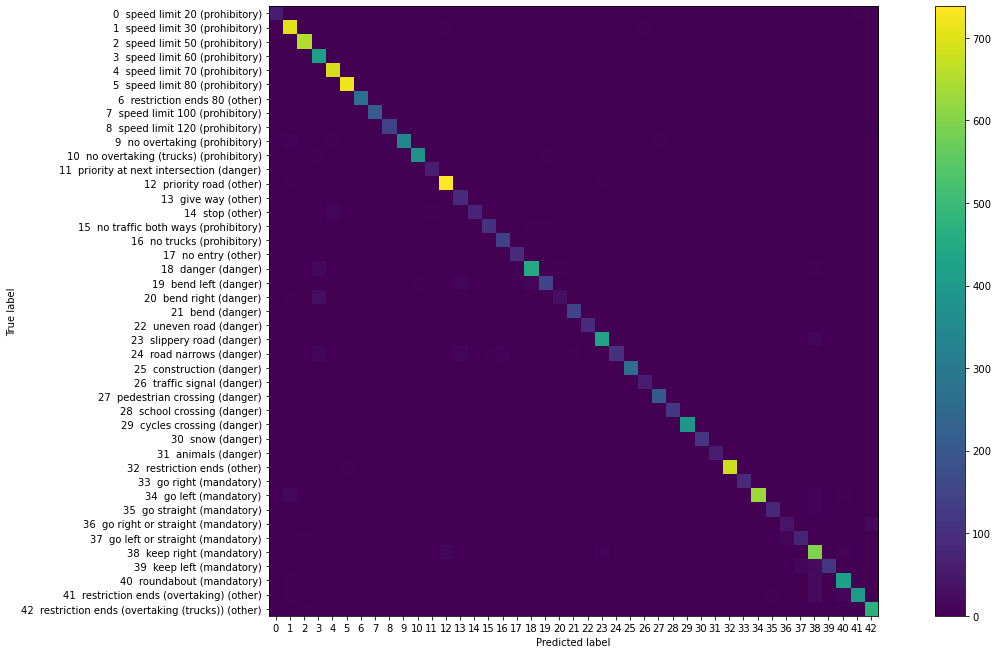

In [124]:
plot_confusion_matrix(cm,Label)